# Préambule

## Introduction & Contexte

Ce projet a été réalisé par 3 étudiants de Master 1 à l'ENSAE, dans le cadre du cours "Python for Data Science". L'idée de ce projet vient d'une intuition que nous avons eu selon laquelle il était possible de prédire le succès d'un jeu vidéo auprès des utilisateurs à partir de certaines de ses caractéristiques. L'objectif principal de ce travail est donc de tenter de vérifier ou infirmer cette intuition à l'aide de techniques statistiques de traitement de données. 

De plus, nous voulions y incorporer une partie plus originale (traitement d'images...)

# Importation des modules 

## Modules de webscrapping

On installe les packages utiles au Webscrapping des données sur les jeux

In [2]:
# On importe les packages
!pip install unicode
!pip install unidecode
!pip install requests_html
!pip install igdb-api-v4
!pip install requests

import requests 
import urllib
import bs4
from requests_html import HTMLSession
from tqdm import tqdm
from unidecode import unidecode
import datetime

from igdb.wrapper import IGDBWrapper
from igdb.igdbapi_pb2 import GenreResult
from igdb.igdbapi_pb2 import ThemeResult
from igdb.igdbapi_pb2 import GameResult
from igdb.igdbapi_pb2 import InvolvedCompanyResult
from igdb.igdbapi_pb2 import PlayerPerspectiveResult
from igdb.igdbapi_pb2 import MultiplayerModeResult
from igdb.igdbapi_pb2 import ArtworkResult
from igdb.igdbapi_pb2 import AgeRatingResult
from igdb.igdbapi_pb2 import CompanyResult
from igdb.igdbapi_pb2 import CollectionResult
from igdb.igdbapi_pb2 import GameEngineResult
from igdb.igdbapi_pb2 import FranchiseResult


#Cela va run le notebook functions_scrapping et nous allons pouvoir utiliser les fonctions dans ce notebook
#%run -i functions_scrapping.ipynb

In [3]:
wrapper = IGDBWrapper("wlqlv1d19z5t69oqlf9xx69znfahze", "o2strnp2xj90l3p982n4jg9ko1utad")

## Importation des modules de Visualisation & Modélisation des données

In [44]:
#Là on importe les autres packages
#!pip install pandas_profiling 

#!pip install pydantic-settings
from collections import Counter
import numpy as np
import pandas as pd
import ast

#from pandas_profiling import ProfileReport
#from pydantic_settings import BaseSettings

SyntaxError: invalid syntax (2522392792.py, line 2)

# I/ Récupération des données

## I/A Webscrapping des titres des jeux vidéos sur Wikipédia

A partir du site Wikipédia, nous allons récupérer les titres de tous les jeux vidéos sortis depuis l'année 2000. Par exemple, depuis l'URL : https://en.wikipedia.org/wiki/Category:2023_video_games nous avons accès à la liste de la quasi-totalité des jeux vidéos sortis en 2023. Nous allons donc modifier l'URL pour chaque année et constituer une liste (Liste_VG)

In [5]:
#Url initial : https://en.wikipedia.org/wiki/2023_in_video_games
Liste_VG = []

d = {15 : 10, 16 : 9, 17: 11, 18 : 9, 19 : 9, 20: 12, 21: 11, 22 : 7}
for i in range(15, 23) :
    
    
    response = requests.get(url="https://en.wikipedia.org/wiki/20"+str(i)+"_in_video_games")
    soup = bs4.BeautifulSoup(response.content, 'html.parser')
    tableau_participants = soup.findAll('table', {'class' : 'wikitable'})
    for j in range(d[i], d[i]+4) :
        rows = tableau_participants[j].find_all('tr')
        first = True
        for row in rows :
            if first :
                first = False
            else:
                title = row.find('i')
                if title != None :
                    Liste_VG.append((row.find('i').text))
                
                    
print(Liste_VG)

['Dark Souls II: Scholar of the First Sin', 'Box Boy!', 'DuckTales Remastered', 'Steven Universe: Attack the Light!', 'War for the Overworld', 'Stealth Inc. 2: A Game of Clones', 'Bastion', 'Dark Souls II: Scholar of the First Sin', 'Etrian Mystery Dungeon', 'Krinkle Krusher', 'MonsterBag', 'Mortal Kombat X', 'Stealth Inc. 2: A Game of Clones', 'Tower of Guns', 'Driver: Speedboat Paradise', 'Bloodsports.TV', 'Pokémon Rumble World', 'Affordable Space Adventures', 'I am Bread', 'Tower of Guns', 'Xenoblade Chronicles 3D', 'A-Train: City Simulator', 'Age of Wonders III', 'Grand Theft Auto V', 'Grand Theft Auto Online', 'Mortal Kombat X', 'Titan Souls', 'We Are Doomed', '3D Fantasy Zone II', 'Goat Simulator', 'Halo: Spartan Assault', 'Halo: Spartan Strike', 'Lost Within', 'Gradius V', 'Slow Down, Bull', "Assassin's Creed Chronicles: China", 'LA Cops', 'Shovel Knight', 'EA Sports UFC', 'Shooting Love 200X', 'Kalimba', 'Crypt of the Necrodancer', 'Dungeons 2', 'Happy Wars', "Shantae and the P

## I/B Récupération des notes des jeux

L'objectif de cette partie est d'extraire du site "Métacritic", un site spécialisé qui répertorie les avis de professionnels et d'utilisateurs sur les nouvelles sorties jeux vidéos. Pour chaque jeu dans la base de données du site, une note sur 100 est attribuée (moyenne des reviews de sites spécialisés jeux vidéos) et une note sur 10 attribuée par les utilisateurs du site. Nous allons ici récupérer pour chaque jeu ses notes Métacritic qui deviendront les variables que nous tenteront de prédire par la suite. 

On remarque que l'on peut atteindre la review du jeu à partir de l'URL, il suffit d'indiquer le titre du jeu dans l'URL, en faisant attention aux espaces. 

Ici, nous allons remarquer que l'accès à Métacritic est interdit via la bibliothèque Beautifoul Soup

In [6]:
#URL du site : https://www.metacritic.com/game/
#URL d'une recherche : https://www.metacritic.com/search/gran%20theft%20auto/
#URL d'une review : https://www.metacritic.com/game/grand-theft-auto-v/
#URL d'une review d'un autre site spécialisé : https://www.ign.com/games/grand-theft-auto-v

#Base URL de toutes les reviews
URL = "https://www.metacritic.com/game/"

#user_agent = {'User-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/62.0.3202.94 Safari/537.36'}
#site = requests.get(URLbis, user_agent)
#print(site.status_code)

In [7]:
def title_to_slug(title):
    
    title = title.lower()
    title = title.replace(':', '')
    title = title.replace('•', '-')
    title = title.replace(' – ', '')
    #ce ne sont pas exactement les mêmes tirets ici
    title = title.replace(' — ', '')
    title = title.replace(' - ', '')
    title = title.replace('/', '-')
    title = title.replace('.', '')
    title = title.replace('&', 'and')
    title = title.replace("'", '')
    title = title.replace('+', 'plus')
    title = title.replace('ō', 'o')
    title = title.replace(' ', '-')
    
    return(str(title))

On définit cette fonction qui va, pour une liste de titres de jeux donnée, récupérer les notes Métacritic sur la page web de la review du jeu en question. Ce sont ces notes que nous allons essayer de prédire par la suite car elles correspondent globablement à la mesure de l'accueil et de la qualité du jeu par les joueurs. 

Afin d'accélérer le code et sachant que nous allons utiliser uniquement le métascore qui reflète les avis de professionnels du milieu du jeu vidéo, nous allons ajouter à l'utilisateur la possibilité de choisir d'extraire le métascore ou le userscore

In [8]:
def recup_metascore(list, param) : 
    session = HTMLSession()
    liste_ratings = []

    if param == 1 :

        for i in range(len(list)) :
            #on reformate les titres extraits pour qu'ils aient le format des URL Métacritic
            title = unidecode(list[i])
            Url = URL + title_to_slug(title) + '/'

            #on get l'url
            DOM_Html = session.get(Url)
            chemin_metascore = DOM_Html.html.find('#__layout > div > div.c-layoutDefault_page > div.c-pageProductGame > div:nth-child(1) > div > div \
                                    > div.c-productHero_player-scoreInfo.u-grid.g-grid-container > \
                                    div.c-productHero_score-container.u-flexbox.u-flexbox-column.g-bg-white > \
                                    div.c-productHero_scoreInfo.g-inner-spacing-top-medium.g-outer-spacing-bottom-medium.g-outer-spacing-top-medium \
                                    > div:nth-child(1) > div > div.c-productScoreInfo_scoreContent.u-flexbox.u-flexbox-alignCenter.u-flexbox-justifyFlexEnd.g-width-100.u-flexbox-nowrap > \
                                    div.c-productScoreInfo_scoreNumber.u-float-right > div > div', first = True)
            #on extrait le rating
            if chemin_metascore != None :
                metacritic_rating_inter = chemin_metascore.attrs['title']
                metacritic_rating = metacritic_rating_inter.split(' ')[1]
            else : 
                metacritic_rating = 'N/A'

            liste_ratings.append([list[i], metacritic_rating])

    elif param == 2 : 

        for i in range(len(list)) :
            #on reformate les titres extraits pour qu'ils aient le format des URL Métacritic
            title = unidecode(list[i])
            Url = URL + title_to_slug(title) + '/'

            #on get l'url
            DOM_Html = session.get(Url)
            chemin_userscore = DOM_Html.html.find('#__layout > div > div.c-layoutDefault_page > div.c-pageProductGame > div:nth-child(1) > div > div > \
                                      div.c-productHero_player-scoreInfo.u-grid.g-grid-container > div.c-productHero_score-container.u-flexbox.u-flexbox-column.g-bg-white > \
                                      div.c-productHero_scoreInfo.g-inner-spacing-top-medium.g-outer-spacing-bottom-medium.g-outer-spacing-top-medium > \
                                      div.c-productScoreInfo.u-clearfix > div.c-productScoreInfo_scoreContent.u-flexbox.u-flexbox-alignCenter.u-flexbox-justifyFlexEnd.g-width-100.u-flexbox-nowrap > \
                                      div.c-productScoreInfo_scoreNumber.u-float-right > div > div' , first = True)
            #On extrait le rating
            if chemin_userscore != None :  
                users_ratings_inter = chemin_userscore.attrs['title']
                users_ratings = float(users_ratings_inter.split(' ')[2])
            else:
                users_ratings = 'N/A'
        
            liste_ratings.append([list[i],  users_ratings])


    return liste_ratings

    

## I/C Récupération des données via l'API

Dans cette partie, nous allons récupérer les informations que nous souhaitons sur la liste de jeux que nous avons extraite afin de constituer notre DataFrame. La communication avec l'API étant un peu difficile, nous créons des fonctions qui vont nous permetttre de réaliser les requêtes sur l'API que nous souhaitons. 

In [9]:
# On crée le dictionnaire des ratings et une fonction pour récupérer le age_rating dans la base
dictionnary_rating = {}
dictionnary_rating[4] = '16 year'
dictionnary_rating[21] = '16 year'
dictionnary_rating[25] = '16 year'
dictionnary_rating[32] = '16 year'
dictionnary_rating[5] = '18 year'
dictionnary_rating[26] = '18 year'
dictionnary_rating[33] = '18 year'
dictionnary_rating[22] = '18 year'

In [10]:
#Création du dictionnaire des différents genres de jeux : chaque genre est associé à un Id qui nous permettra de nous repérer dans le base# 
byte_array = wrapper.api_request(
            'genres.pb',
            'fields *; limit 100;'
          )
genres_message = GenreResult()
genres_message.ParseFromString(byte_array) # Fills the protobuf message object with the response
genres = genres_message.genres
genre_nbr = len(genres)
genre_dictionnary = {}
for i in range(genre_nbr) :
    genre_dictionnary[genres[i].id] = genres[i].name


#Création du dictionnaire des différents thèmes de jeux : chaque thème est associé à un Id qui nous permettra de nous repérer dans le base
byte_array = wrapper.api_request(
            'themes.pb',
            'fields *; limit 100;'
          )
themes_message = ThemeResult()
themes_message.ParseFromString(byte_array)# Fills the protobuf message object with the response
themes = themes_message.themes
theme_nbr = len(themes)
theme_dictionnary = {}
for i in range(theme_nbr) :
    theme_dictionnary[themes[i].id] = themes[i].name


#Fonction aller chercher nb_pixels dans la table adéquat
def fetch_artwork(id) : 
    byte_array = wrapper.api_request(
            'artworks.pb',
            f'fields *; where id = {id};'
          )
    artwork_message = ArtworkResult()
    artwork_message.ParseFromString(byte_array)# Fills the protobuf message object with the response
    artworks = artwork_message.artworks
    longueur = artworks[0].width
    largeur = artworks[0].height
    nb_pixels = largeur * longueur

    return nb_pixels


#Requête pour aller chercher age_rating dans le base
def fetch_age_ratings(id) :
    byte_array = wrapper.api_request(
                'age_ratings.pb',
                f'fields *; where id = {id};'
              )
    age_rating_message = AgeRatingResult()
    age_rating_message.ParseFromString(byte_array)# Fills the protobuf message object with the response
    ageratings = age_rating_message.ageratings

    if ageratings[0].rating in dictionnary_rating :
        PEGI = dictionnary_rating[ageratings[0].rating]
    else : 
        PEGI = 'Tout Public'

    return(PEGI)


#Requête pour aller chercher age_rating dans le base
def fetch_player_perspective(id) :
    byte_array = wrapper.api_request(
                'player_perspectives.pb',
                f'fields *; where id = {id};'
              )
    pp_message = PlayerPerspectiveResult()
    pp_message.ParseFromString(byte_array)# Fills the protobuf message object with the response
    playerperspectives = pp_message.playerperspectives

    pp = playerperspectives[0].name

    return(pp)


#Requête pour les companies
def fetch_involved_company(id, param) :
    if param == 1 : 
      byte_array = wrapper.api_request(
                  'involved_companies.pb',
                  f'fields *; where id = {id};'
                )
      involved_company_message = InvolvedCompanyResult()
      involved_company_message.ParseFromString(byte_array)# Fills the protobuf message object with the response
      involvedcompanies = involved_company_message.involvedcompanies

      if involvedcompanies[0].publisher == True : 
        return(involvedcompanies[0].company.id)
      else : 
        return('NA')

    elif param == 2 : 
      byte_array = wrapper.api_request(
                  'involved_companies.pb',
                  f'fields *; where id = {id};'
                )
      involved_company_message = InvolvedCompanyResult()
      involved_company_message.ParseFromString(byte_array)# Fills the protobuf message object with the response
      involvedcompanies = involved_company_message.involvedcompanies
      
      if involvedcompanies[0].developer == True : 
        return(involvedcompanies[0].company.id)
      else : 
        return('NA')
      

def fetch_company_name(id) : 
    byte_array = wrapper.api_request(
                'companies.pb',
                f'fields *; where id = {id};'
              )
    company_message = CompanyResult()
    company_message.ParseFromString(byte_array)# Fills the protobuf message object with the response
    companies = company_message.companies

    companies = companies[0].name

    return(companies)


#Requête multiplayer
def fetch_multiplayer(id) :
    byte_array = wrapper.api_request(
                'multiplayer_modes.pb',
                f'fields *; where id = {id};'
              )
    mm_message = MultiplayerModeResult()
    mm_message.ParseFromString(byte_array)# Fills the protobuf message object with the response
    multiplayermodes = mm_message.multiplayermodes

    mm1 = multiplayermodes[0].campaigncoop
    mm2 = multiplayermodes[0].offlinecoop
    mm3 = multiplayermodes[0].onlinecoop

    if mm1 == True or mm2 == True or mm3 == True : 
        return('Yes')
    else : 
        return('No')
    

#Requête pour avoir les collections 
def fetch_collection(id) :
    byte_array = wrapper.api_request(
                'collections.pb',
                f'fields *; where id = {id};'
              )
    collection_message = CollectionResult()
    collection_message.ParseFromString(byte_array)# Fills the protobuf message object with the response
    collections = collection_message.collections
    
    return(collections[0].name)


#Requête Game_engine
def fetch_game_engines(id) : 
    byte_array = wrapper.api_request(
                'game_engines.pb',
                f'fields *; where id = {id};'
              )
    game_engines_message = GameEngineResult()
    game_engines_message.ParseFromString(byte_array)# Fills the protobuf message object with the response
    gameengines = game_engines_message.gameengines

    return(gameengines[0].name)

#Requête Franchise
def fetch_franchise(id) : 
    byte_array = wrapper.api_request(
                'franchises.pb',
                f'fields *; where id = {id};'
              )
    franchise_message = FranchiseResult()
    franchise_message.ParseFromString(byte_array)# Fills the protobuf message object with the response
    franchise = franchise_message.franchise

    return(franchise[0].name)

Ici, la fonction permet de centraliser toutes les requêtes à l'API et crée une liste de chaque caractéristique par jeu

In [11]:
import datetime

def game_API_Info(game_slug) :

    #Protobuf API request
    from igdb.igdbapi_pb2 import GameResult
    #On fait cela non pas pour préciser si le jeu n'ai pas dispo sur l'api mais si jamais des caractères dans son titre empêchent sa lecture 
    #(utile pour affiner la fonction de reformatage des titres)
    try : 
        byte_array = wrapper.api_request(
                'games.pb',
                'fields first_release_date, franchise, genres, hypes, language_supports, platforms, themes, age_ratings, collection, artworks, \
                involved_companies, multiplayer_modes, player_perspectives, similar_games, summary, storyline, game_engines \
                ; where slug = "'+ game_slug +'";'
              )
    except: 
        print(f"Une erreur d'extraction s'est produite pour le jeu {game_slug}")
        return(["NA"])
    games_message = GameResult()
    games_message.ParseFromString(byte_array) # Fills the protobuf message object with the response
    games = games_message.games
    
    if len(games) == 0 :
        return(["NA"])
    unix_time = games[0].first_release_date
    seconds = unix_time.seconds
    dt_object = datetime.datetime.utcfromtimestamp(seconds)
    year = dt_object.year
    
    genres_nbr = len(games[0].genres)
    genres_names_list = []
    for j in range(genres_nbr):
        genres_names_list.append(genre_dictionnary[games[0].genres[j].id])

    themes_nbr = len(games[0].themes)
    themes_names_list = []
    for j in range(themes_nbr):
        themes_names_list.append(theme_dictionnary[games[0].themes[j].id])
        
    #requête pour le nb de pixels
    if len(games[0].artworks) == 0 : 
        nb_pixels = 'NA'
    else : 
        nb_pixels = fetch_artwork(games[0].artworks[0].id)

    #requête pegi rating
    if len(games[0].age_ratings) == 0 : 
        age_rating_pegi = 'NA'
    else : 
        for i in range(len(games[0].age_ratings)): 
            age_rating_pegi = 'Tout Public'
            age_rating_bis = fetch_age_ratings(games[0].age_ratings[i].id)
            if age_rating_bis != 'Tout Public': 
                age_rating_pegi = age_rating_bis
                break

    #requête player_perspective
    if len(games[0].player_perspectives) == 0 : 
        player_perspectives = 'NA'
    else : 
        player_perspectives = fetch_player_perspective(games[0].player_perspectives[0].id)

    #requête Publisher/developer
    if len(games[0].involved_companies) == 0 : 
        publisher = 'NA'
        developer = 'NA'
    else : 
        publisher = []
        developer = []
        for i in range(len(games[0].involved_companies)) :
            involved_id1 = fetch_involved_company(games[0].involved_companies[i].id, 1)
            involved_id2 = fetch_involved_company(games[0].involved_companies[i].id, 2)
            if involved_id1 != 'NA' : 
                company_id = fetch_company_name(involved_id1)
                publisher.append(company_id)
            if involved_id2 != 'NA' : 
                company_id = fetch_company_name(involved_id2)
                developer.append(company_id)
    
    #Liste des similar games
    similar_games = []
    for i in range(len(games[0].similar_games)) : 
        similar_games.append(games[0].similar_games[i].id)
    
    #Requête pour multiplayer
    if len(games[0].multiplayer_modes) == 0 : 
        multi = 'NA'
    else : 
        multi = fetch_multiplayer(games[0].multiplayer_modes[0].id)

    #Requête pour collection
    if games[0].collection is None or games[0].collection == [] : 
        collec = 'NO'
    else : 
        collec = 'Yes'

    #Requête Game_Engine
    if len(games[0].game_engines) == 0 : 
        game_engines = 'NA'
    else : 
        game_engines = fetch_game_engines(games[0].game_engines[0].id)

    #Requête franchise
    if len(games[0].franchises) == 0 : 
        franchises = 'NA'
    else : 
        franchises = fetch_franchise(games[0].franchises.id)
                
    return([games[0].id, year, age_rating_pegi, franchises, genres_names_list, games[0].hypes, len(games[0].language_supports), \
            len(games[0].platforms), themes_names_list, collec, nb_pixels, \
            publisher, developer, multi, player_perspectives, \
            similar_games, game_engines, games[0].summary, games[0].storyline])

Ici on va créer le dataframe qui rassemble les informations disponibles sur la base de l'API ainsi que les notes Métacritic des jeux

In [12]:
def creation_dataframe(list) : 
    np_df = []
    k = 0

    for i in tqdm(range(len(list))) :
        data_recup = recup_metascore([list[i]], 1)
        titre = data_recup[0][0]
        metascore = data_recup[0][1]
        slug = title_to_slug(list[i])
        vect_info_jeu = game_API_Info(slug)
        #Ici on vient filtrer les jeux qui ne sont pas répertoriés dans la base de données (vecteur d'informations = 'NA')
        
        if len([titre] + [metascore] + vect_info_jeu) == 21 : 
            np_df.append([titre] + [metascore] + vect_info_jeu)
        elif vect_info_jeu == ['NA'] : 
            k += 1
       
    np_DF = pd.DataFrame(np_df, columns = ['Title', 'Note', 'Id', 'Date de Sortie', 'Age Rating', 'Franchise', 'Genres', 'Hypes', 'nb_languages', \
                                                    'nb_platforms', 'Themes', 'Collection', 'Graphismes', 'Publisher','Developer', 'Multiplayer', \
                                                    'Perspective', 'Similar Games', 'Game Engine', 'Summary', 'Storyline'])
    
    print(f"La proportion de jeux qui ont matché avec la base de l'API est de {int(1000*(len(list) - k)/len(list))/10} %")
    return(np_DF)

## Création d'un fichier .csv

Nous pouvons maintenant créer notre dataframe. Comme nous avons presque 5000 jeux à extraire et que l'extraction des infos pour un jeu prend environ 10 secondes, nous allons subdiviser notre liste initiale en plusieurs parties et  créer plusieurs petits dataframes que l'on fusionnera ensuite. Cela permet d'éviter de faire tourner le programme pendant 11h et de s'exposer à des problèmes de fermeture de session ou autre pendant l'extraction. 

Au vu du temps d'éxécution pour extraire l'ensemble des données de la base, nous allons créer des fichiers .csv pour éviter de tout recharger à chaque fois.

In [ ]:
DF_VG1 = creation_dataframe(Liste_VG[:500])
DF_VG1.to_csv('W:\\Bureau\\projet python\\BDD1.csv',index=False) 

In [ ]:
DF_VG2 = creation_dataframe(Liste_VG[500:1000])
DF_VG2.to_csv('W:\Bureau\projet python\BDD2.csv',index=False) 

In [ ]:
DF_VG3 = creation_dataframe(Liste_VG[1000:1500])
DF_VG3.to_csv('W:\Bureau\projet python\BDD3.csv',index=False)

In [ ]:
DF_VG4 = creation_dataframe(Liste_VG[1500:2000])
DF_VG4.to_csv('W:\Bureau\projet python\BDD4.csv',index=False)

In [ ]:
DF_VG5 = creation_dataframe(Liste_VG[2000:3000])
DF_VG5.to_csv('W:\Bureau\projet python\BDD5.csv',index=False)

In [ ]:
DF_VG6 = creation_dataframe(Liste_VG[3000:4000])
DF_VG6.to_csv('W:\Bureau\projet python\BDD6.csv',index=False)

In [ ]:
DF_VG7 = creation_dataframe(Liste_VG[4000:4500])
DF_VG7.to_csv('W:\Bureau\projet python\BDD7.csv',index=False)

In [ ]:
DF_VG8 = creation_dataframe(Liste_VG[4500:4891])
DF_VG8.to_csv('W:\Bureau\projet python\BDD8.csv',index=False)

Comme l'extraction est très longue puisque Liste_VG contient 4891 jeux vidéos, vous pouvez tester le code avec ce petit dataframe qui n'extrait que 20 jeux vidéos. 

In [19]:
DF_VGtest = creation_dataframe(Liste_VG[:20])

 10%|█         | 2/20 [00:13<02:00,  6.71s/it]


HTTPError: 429 Client Error: Too Many Requests for url: https://api.igdb.com/v4/player_perspectives.pb

In [204]:
DF_VGtest.head()

NameError: name 'DF_VGtest' is not defined

Maintenant, on peut fusionner tous nos fichiers .csv afin de créer une unique base de données 

In [117]:
df=[]
BDD=['BDD1.csv','BDD2.csv','BDD3.csv','BDD4.csv','BDD5.csv','BDD6.csv','BDD7.csv','BDD8.csv']
dfs=[pd.read_csv(bdd) for bdd in BDD]
df=pd.concat(dfs, ignore_index=True)
df.tail()

,Title,Note,Id,Date de Sortie,Age Rating,Franchise,Genres,Hypes,nb_languages,nb_platforms,...,Collection,Graphismes,Publisher,Developer,Multiplayer,Perspective,Similar Games,Game Engine,Summary,Storyline
4153,Naraka: Bladepoint,71.0,127352,2021,16 year,NaN,"['Fighting', ""Hack and slash/Beat 'em up""]",4,38,4,...,Yes,1190400.0,['NetEase Games Montréal'],['24 Entertainment'],No,Third person,"[54775, 55199, 89550, 96217, 101608, 103168, 1...",Unity,Naraka: Bladepoint is a 60-player action Battl...,NaN
4154,Uta no Prince-sama All Star After Secret,NaN,56323,2015,Tout Public,NaN,"['Music', 'Simulator', 'Visual Novel']",0,0,1,...,Yes,NaN,['Broccoli'],['Nippon Ichi Software'],NaN,Text,"[11778, 17906, 19075, 27259, 56298, 56321, 563...",NaN,"Sequel of Uta no Prince-sama All Star, with th...",This game will focus on the 4 senior idols. Co...
4155,Valkyrie Profile: Lenneth,80.0,22756,2006,Tout Public,NaN,"['Platform', 'Role-playing (RPG)', 'Simulator']",0,2,3,...,Yes,8294400.0,['Square Enix'],['tri-Ace'],NaN,Third person,"[19164, 24426, 54775, 55199, 81249, 96217, 103...",NaN,Valkyrie Profile: Lenneth is the PlayStation P...,NaN
4156,Sports Story,54.0,127303,2022,Tout Public,NaN,"['Role-playing (RPG)', 'Sport', 'Adventure', '...",0,1,1,...,Yes,810000.0,['Sidebar Games'],['Sidebar Games'],NaN,Bird view / Isometric,"[25311, 28309, 30245, 35994, 36198, 80916, 962...",NaN,"Sports story is a game about sports, but not a...",Embark on a golfing adventure in both ordinary...
4157,Hyper Gunsport,NaN,204825,2022,16 year,NaN,"['Sport', 'Indie', 'Arcade']",0,11,8,...,Yes,1190400.0,['Necrosoft Games'],['Necrosoft Games'],NaN,Side view,"[15851, 22690, 43367, 56033, 59858, 96217, 111...",NaN,An arcade action game about shooting a ball in...,"""There is no more war. There are no more gods...."


# II/ Nettoyage des données extraites

## A/ Première visualisation des données


In [118]:
ProfileReport(df) #-> le package marche pas zbi

NameError: name 'ProfileReport' is not defined

In [119]:
df['Title'].describe()

count                       4158
unique                      3244
top       Phoenotopia: Awakening
freq                           7
Name: Title, dtype: object

## B/ Reformatage et standardisation des données dans le dataframe

Créer des colonnes binaires par genres/thèmes

Nous enlevons les jeux dont on n'a pas extrait la note -> pas de review disponible sur le Métacritic ou sous un autre nom donc difficile

In [120]:
idx = df.loc[df['Note'] == 'N/A'].index
DF = df.drop(idx)
DF=DF.dropna(subset=['Note'])
DF=DF.reset_index()
DF

,index,Title,Note,Id,Date de Sortie,Age Rating,Franchise,Genres,Hypes,nb_languages,...,Collection,Graphismes,Publisher,Developer,Multiplayer,Perspective,Similar Games,Game Engine,Summary,Storyline
0,0,Dark Souls II: Scholar of the First Sin,87.0,8222,2015,16 year,NaN,"['Role-playing (RPG)', 'Adventure']",5,21,...,Yes,2073600.0,['Bandai Namco Entertainment'],['FromSoftware'],Yes,Third person,"[9243, 10776, 17548, 25300, 26574, 36198, 8124...",NaN,'Dark Souls II: Scholar of the First Sin' is a...,NaN
1,1,DuckTales Remastered,70.0,2904,2013,Tout Public,id: 125\n,"['Platform', 'Adventure']",0,14,...,Yes,1152000.0,"['Capcom', 'Disney Interactive']","['Capcom', 'WayForward']",NaN,Side view,"[3022, 7344, 7350, 9174, 9938, 11646, 16992, 2...",NaN,DuckTales Remastered takes the classic Disney ...,The Beagle Boys attempt another raid on Scroog...
2,2,War for the Overworld,65.0,1878,2015,NaN,NaN,"['Real Time Strategy (RTS)', 'Simulator', 'Str...",4,21,...,Yes,NaN,['Brightrock Games'],['Brightrock Games'],NaN,First person,"[9278, 9789, 10297, 10388, 10774, 11646, 15409...",Unity,Tired of invading dungeons? It's time you buil...,NaN
3,3,Stealth Inc. 2: A Game of Clones,82.0,17959,2014,Tout Public,NaN,"['Platform', 'Puzzle', 'Adventure', 'Indie']",0,12,...,Yes,8294400.0,['Curve Digital'],"['Carbon Games', 'Curve Studios', 'Curve Digit...",NaN,NaN,"[19150, 20329, 20342, 24426, 28070, 36198, 551...",NaN,"In Stealth Inc 2, you play the role of a clone...",NaN
4,4,Bastion,86.0,1983,2011,16 year,NaN,"['Role-playing (RPG)', 'Adventure', 'Indie']",0,13,...,Yes,2287800.0,"['WB Games', 'Supergiant Games']",['Supergiant Games'],NaN,Bird view / Isometric,"[3022, 3025, 7344, 9278, 9806, 9938, 11646, 26...",Microsoft XNA,A hack-and-slash RPG featuring a reactive narr...,The game takes place in the aftermath of the C...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3577,4148,Turnip Boy Commits Tax Evasion,74.0,128097,2021,Tout Public,NaN,"['Puzzle', 'Role-playing (RPG)', 'Adventure', ...",0,26,...,Yes,2073600.0,['Graffiti Games'],['Snoozy Kazoo'],NaN,Bird view / Isometric,"[19164, 24426, 25646, 28070, 36198, 55199, 809...",Unity,"Avoid paying taxes, solve plantastic puzzles, ...",After failing to pay taxes and getting evicted...
3578,4149,Sail Forth,77.0,115491,2022,Tout Public,NaN,"['Racing', 'Role-playing (RPG)', 'Simulator', ...",0,11,...,Yes,810000.0,['The Quantum Astrophysicists Guild'],['David Evans'],NaN,Third person,"[25311, 26574, 28182, 35994, 79134, 80916, 962...",NaN,Heave! Fake the bull rope and stay the mizzen ...,NaN
3579,4153,Naraka: Bladepoint,71.0,127352,2021,16 year,NaN,"['Fighting', ""Hack and slash/Beat 'em up""]",4,38,...,Yes,1190400.0,['NetEase Games Montréal'],['24 Entertainment'],No,Third person,"[54775, 55199, 89550, 96217, 101608, 103168, 1...",Unity,Naraka: Bladepoint is a 60-player action Battl...,NaN
3580,4155,Valkyrie Profile: Lenneth,80.0,22756,2006,Tout Public,NaN,"['Platform', 'Role-playing (RPG)', 'Simulator']",0,2,...,Yes,8294400.0,['Square Enix'],['tri-Ace'],NaN,Third person,"[19164, 24426, 54775, 55199, 81249, 96217, 103...",NaN,Valkyrie Profile: Lenneth is the PlayStation P...,NaN


Pour les variables perspective et age_rating, on va créer des colonnes binaire qui précisent si oui ou non chaque jeu fait partie de cette catégorie

In [149]:
DF = DF.fillna('NA')

for i in list(DF['Perspective'].unique()) : 
    DF[f'{i}'] = DF['Perspective'].str.contains(f'{i}', case = False).astype(bool)

for i in list(DF['Age Rating'].unique()) : 
    DF[f'{i}'] = DF['Age Rating'].str.contains(f'{i}', case = False).astype(bool)

DF.drop(['NA'], axis = 1, inplace = True)

Ici on crée des colonnes pour chaque genres et thèmes. Pour chaque jeu on y rentre le booléen disant si oui ou non le jeu fait partie de cette catégorie. 

In [122]:
#On transforme pour chaque jeu la liste de genres en string qui les rassemblent
col_genres = []
for i in DF.index :
        genre = str() 
        for j in range(len(DF['Genres'][i])) : 
            genre = genre + str(DF['Genres'][i][j])
        col_genres.append(genre)

DF['Genres'] = col_genres

for i in genre_dictionnary : 
    DF[genre_dictionnary[i]]= DF['Genres'].str.contains(genre_dictionnary[i], case=False).astype(bool)


/tmp/ipykernel_251/2182681408.py:12: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  DF[genre_dictionnary[i]]= DF['Genres'].str.contains(genre_dictionnary[i], case=False).astype(bool)
/tmp/ipykernel_251/2182681408.py:12: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  DF[genre_dictionnary[i]]= DF['Genres'].str.contains(genre_dictionnary[i], case=False).astype(bool)
/tmp/ipykernel_251/2182681408.py:12: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  DF[genre_dictionnary[i]]= DF['Genres'].str.contains(genre_dictionnary[i], case=False).astype(bool)


In [123]:
#On transforme pour chaque jeu la liste de themes en string qui les rassemblent
col_themes = []
for i in DF.index :
        theme = str() 
        for j in range(len(DF['Themes'][i])) : 
            theme = theme + str(DF['Themes'][i][j])
        col_themes.append(theme)

DF['Themes'] = col_themes

for i in theme_dictionnary : 
    DF[theme_dictionnary[i]]= DF['Themes'].str.contains(theme_dictionnary[i], case=False).astype(bool)

/tmp/ipykernel_251/1600967716.py:12: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  DF[theme_dictionnary[i]]= DF['Themes'].str.contains(theme_dictionnary[i], case=False).astype(bool)


Ici on va créer une variable qui pourra s'avérer utile qui est la note moyenne qu'on obtenu les jeux similaires par métacritic (s'ils sont dans la base). Aucun des id dans Similar Games ne sont dans la base donc il faudrait récupérer leur name en faisant une requête à l'API et leur note sur Métacritic si on veut construire cette variable

In [124]:
for i in range(len(DF['Similar Games'])) :
    list_id = eval(DF['Similar Games'].loc[i])
    #car on a ici une liste qui a été convertie en string
    list_moy = []
    moy = 0 
    k = 0
    note = 0
    for id in list_id : 
        ISIN = DF['Id'].isin([f'{id}'])
        if len(DF['Note'].loc[ISIN[ISIN].index]) > 1 :
            note = int(DF['Note'].loc[ISIN[ISIN].index][0])
        elif len(DF['Note'].loc[ISIN[ISIN].index]) == 1: 
            note = int(str(DF['Note'].loc[ISIN[ISIN].index]))
        moy += note
        k += 1
    list_moy.append(moy)
    
    

In [125]:
DF.columns

Index(['index', 'Title', 'Note', 'Id', 'Date de Sortie', 'Age Rating',
       'Franchise', 'Genres', 'Hypes', 'nb_languages', 'nb_platforms',
       'Themes', 'Collection', 'Graphismes', 'Publisher', 'Developer',
       'Multiplayer', 'Perspective', 'Similar Games', 'Game Engine', 'Summary',
       'Storyline', 'Third person', 'Side view', 'First person',
       'Bird view / Isometric', 'Virtual Reality', 'Text', 'Auditory',
       '16 year', 'Tout Public', '18 year', 'Fighting', 'Shooter', 'Music',
       'Platform', 'Puzzle', 'Racing', 'Real Time Strategy (RTS)',
       'Role-playing (RPG)', 'Simulator', 'Sport', 'Strategy',
       'Turn-based strategy (TBS)', 'Tactical', 'Quiz/Trivia',
       'Hack and slash/Beat 'em up', 'Pinball', 'Adventure', 'Arcade',
       'Visual Novel', 'Indie', 'Card & Board Game', 'MOBA', 'Point-and-click',
       'Thriller', 'Science fiction', 'Action', 'Horror', 'Survival',
       'Fantasy', 'Historical', 'Stealth', 'Comedy', 'Business', 'Drama',
       

Maintenant, on va créer des booléens pour les développeurs des jeux vidéos contenus dans DF: il s'agit d'informations très intéressantes car on n'a pu extraire le budget de production des jeux alors que cela a probablement un fort impact sur la note du jeu. Néanmoins, on sait que les gros développeurs qui produisent énormément de jeux ont souvent des budgets énormes, donc on peut en quelque sorte créer un proxy du budget avec cette info. 
Pour réaliser cela, comptons d'abord le nombre d'occurence des développeurs les plus fréquents de la liste. 

In [126]:
developpeurs = []
for i in DF.index :
    if DF['Developer'][i]==[]:
        i=i+1
    elif DF['Developer'][i]=='NA':
        i=i+1
    else:
        dev = str()
        for j in range(len(eval(DF['Developer'][i]))): 
            dev=dev+str(eval(DF['Developer'][i])[j])
        developpeurs.append(dev)

print("Il y a au total",len(set(developpeurs)),"développeurs différents dans DF")

compteur = Counter(developpeurs)
dev_frequents = compteur.most_common(20)

print("Les développeurs les plus fréquents sont :")
for element, frequence in dev_frequents:
    print(f"{element}: {frequence} fois")

Il y a au total 1644 développeurs différents dans DF
Les développeurs les plus fréquents sont :
: 59 fois
Square Enix: 42 fois
Capcom: 33 fois
Nihon Falcom: 30 fois
Milestone: 23 fois
Ryū Ga Gotoku Studios: 23 fois
Nippon Ichi Software: 20 fois
Spike ChunSoft: 19 fois
Atlus: 19 fois
Ubisoft Montreal: 19 fois
WayForward: 18 fois
Arc System Works: 16 fois
Omega Force: 16 fois
Grasshopper Manufacture: 16 fois
Codemasters: 15 fois
Visual Concepts: 14 fois
Gust: 14 fois
Blizzard Entertainment: 13 fois
PlatinumGames: 13 fois
Inti Creates: 13 fois


De façon arbitraire, considérons que les développeurs les plus importants sont ceux qui produisent plus de 20 jeux. On créé alors les booléens des developpeurs les plus important, évidemment sans compter '' comme développeur ! 

In [127]:
dev_frequents = ['Square Enix','Capcom', 'Nihon Falcom','Milestone','Ryū Ga Gotoku Studios','Nippon Ichi Software']

for i in dev_frequents:
    DF[i]=DF['Developer'].str.contains(str(i), case=False).astype(bool)

De même, l'attribut 'Publisher' d'un jeu peut être un bon proxy de son , car on peut supposer que les producteurs qui publient le plus de jeux sont souvent ceux qui ont le plus gros budget (c'est sûrement moins le cas avec des jeux mobiles qui sont peu coûteux à produire, mais de toute façon notre base de donnée que contient que des jeux console/ordinateur). 
On va donc créer des booléens pour les producteurs les plus fréquents des jeux, en raisonnant exactement comme au dessus. 

In [128]:
publishers = []
for i in DF.index :
    if DF['Publisher'][i]==[]:
        i=i+1
    elif DF['Publisher'][i]=='NA':
        i=i+1
    else:
        pub = str()
        for j in range(len(eval(DF['Publisher'][i]))): 
            pub=pub+eval(DF['Publisher'][i])[j]
        publishers.append(pub)
       


print("Il y a au total",len(set(publishers)),"producteurs différents dans DF")

compteur = Counter(publishers)
publishers_frequents = compteur.most_common(20)

print("Les producteurs les plus fréquents sont :")
for element, frequence in publishers_frequents:
    print(f"{element}: {frequence} fois")

Il y a au total 1248 producteurs différents dans DF
Les producteurs les plus fréquents sont :
Nintendo: 95 fois
Square Enix: 94 fois
Bandai Namco Entertainment: 84 fois
: 62 fois
Capcom: 62 fois
Devolver Digital: 61 fois
Sony Interactive Entertainment: 61 fois
Electronic Arts: 46 fois
Activision: 42 fois
Ubisoft Entertainment: 41 fois
Focus Entertainment: 37 fois
Team17: 34 fois
THQ Nordic: 33 fois
Sega: 32 fois
EA Sports: 27 fois
Annapurna Interactive: 27 fois
Bethesda Softworks: 26 fois
WB Games: 22 fois
Xbox Game Studios: 22 fois
Microsoft Studios: 21 fois


Crééons un booléen avec les producteurs qui produisent plus de 30 jeux (arbitraire). Certains développeurs sont aussi des producteurs (ex: Square Enix) donc il faut distinguer le producteur du développeur, car son influence est peut-être différente en fonction de son statut sur la qualité donc la note du jeu ?

In [129]:
prod_frequents=['Nintendo','Square Enix','Bandai Namco Entertainment', 'Capcom', 'Devolver Digital', 'Sony Interactive Entertainment',
                'Electronic Arts', 'Activision', 'Ubisoft Entertainment','Focus Entertainment','Team17', 'THQ Nordic',
                'Sega']

for i in prod_frequents:
    DF[i + ' producteur']=DF['Publisher'].str.contains(str(i), case=False).astype(bool)

On va aussi créer des booléens pour les game engine (les logiciels utilisés pour développer le jeu) utilisés les plus fréquemment, car on peut aussi supposer que ça peut influencer sur la qualité et la note du jeu.

In [130]:
gameengine = []
for i in DF.index :
    if DF['Game Engine'][i]==[]:
        i=i+1
    elif DF['Game Engine'][i]=='NA':
        i=i+1
    else:
        gameengine.append(DF['Game Engine'][i])
       


print("Il y a au total",len(set(gameengine)),"game engine différents dans DF")

compteur = Counter(gameengine)
ge_frequents = compteur.most_common(20)

print("Les game engines les plus fréquents sont :")
for element, frequence in ge_frequents:
    print(f"{element}: {frequence} fois")

Il y a au total 205 game engine différents dans DF
Les game engines les plus fréquents sont :
Unity: 388 fois
Unreal Engine 4: 228 fois
Unreal Engine: 130 fois
PhyreEngine: 27 fois
MT Framework: 23 fois
Microsoft XNA: 20 fois
GameMaker: Studio: 20 fois
Unreal Engine 3: 19 fois
Custom built engine: 18 fois
Unity 2017: 17 fois
Frostbite: 16 fois
Dragon Engine: 15 fois
AnvilNext: 14 fois
Ego Engine: 13 fois
RE Engine: 10 fois
CryEngine: 9 fois
Proprietary Engine: 9 fois
Decima: 7 fois
Frostbite 3: 7 fois
GameMaker Studio 2: 7 fois


On voit que les game engine qui reviennent le plus sont de loin Unity et Unreal Engine. L'utilisation d'autres game engine est anectodique. Pour éviter de créer trop de variables et pour avoir des booléens qui sont vraiment significatifs, on va créer un seul booléen qui affiche "true" pour les différentes version d'un game engine (exemple: Unity, Unity 2017, Unity3D...)

In [131]:
game_engine = ['Unity', 'Unreal Engine']

for i in game_engine:
    DF[i]=DF['Game Engine'].str.contains(str(i), case=False).astype(bool)

Enfin, on va rendre la colonne 'Franchise' utilisable et la transformer en un booléen. Si le jeu fait partie d'une franchise (=collection d'une série de jeux), la colonne vaudra 1, 0 sinon. 

In [132]:
### a revoir
DF['Franchise bool']=0
for i in DF.index:
    if DF['Franchise'][i] == 'NA':
        DF.loc[i, 'Franchise bool'] = 0
    else:
        DF.loc[i, 'Franchise bool'] = 1
   

Avant de passer à la visualisation des données, supprimons les colonnes qui sont désormais obsolètes. 

In [133]:
#utile de garder ces colonnes pour visualisation
#DF=DF.drop(['Age Rating','Franchise','Genres','Themes', 'Perspective', 'Publisher','Developer','Perspective','Game Engine'],axis=1)

In [134]:
pas sur de si il faut supprimer collection, similar games, summary, storyline

SyntaxError: invalid syntax (2866325424.py, line 1)

# III/ Visualisation et analyse graphique de nos données 

## III/A Analyse de la répartition des données 

Commençons par étudier les jeux qui se trouvent dans notre base de données: Il est pertinent de se poser les questions suivantes:

-Quels sont les principaux genres des jeux dans notre base de donnée ? 

-Sont-ce des jeux de guerre, de course, de stratégie ou autre ?

-Sont-ils plutôt tout public ou "pegi 18" ? 

-S'agit-il de jeux solos ou plutôt multiplayer ? 

-Quelles sont les plateformes principales qui font tourner les jeux de la base ?

-Quelle est la répartition entre les gros producteurs et développeurs ? 

### III/A/1 Répartition des différents types de jeux vidéos 

Commençons par étudier la répartition de perspectives des jeux vidéos. Il peut s'agir de jeux à la 1e ou 3e personne, de jeux "bird view" (ie vue du dessus, comme dans pokémon), de jeux "side vue" (ie vue de côté, comme dans mario bros), ou en VR. Les jeux de la catégorie 'Text' sont des histoires interactives où le joueur doit faire évoluer le scénario en choisissant différents paragraphes au fur et à mesure du gameplay.
Enfin, les jeux de catégorie 'Auditory' sont des jeux de karaoké. 

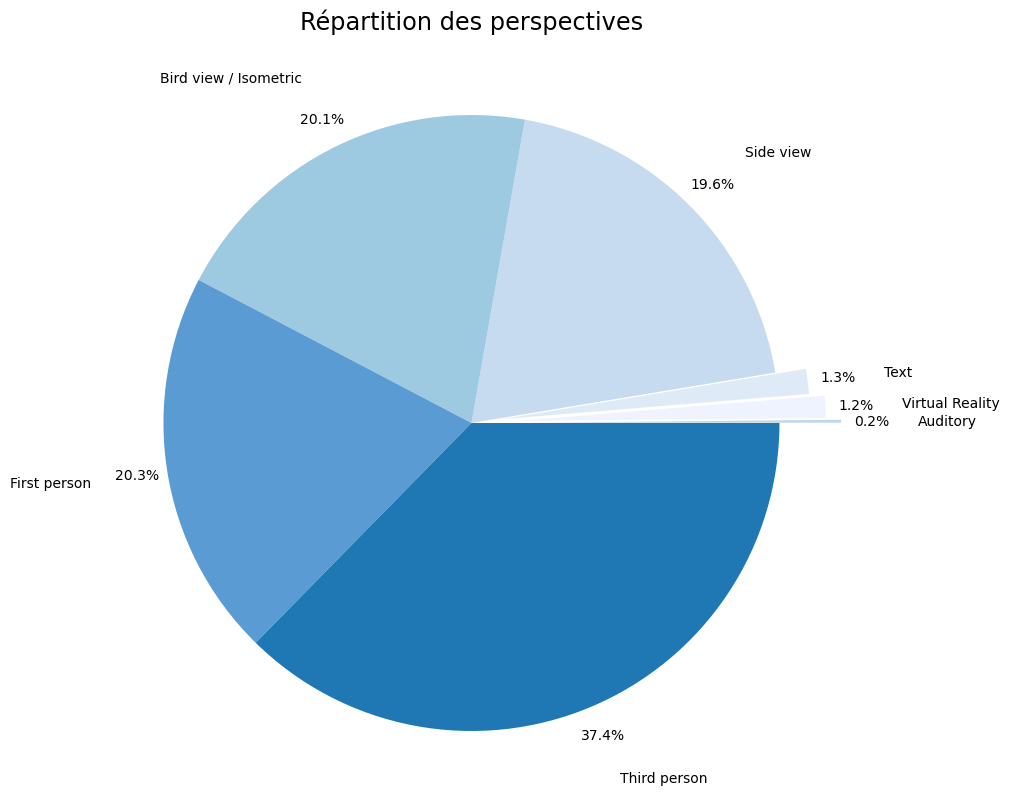

In [213]:
colonnes_cam = ['Auditory', 'Bird view / Isometric', 'First person', 'Side view', 'Text', 'Third person', 'Virtual Reality']
df_cam = DF[colonnes_cam].sum().sort_values()
myexplode = [0.4, 0.3, 0.2, 0,0,0,0]
dégradé7 = ['#bdd7e7','#eff3ff','#deebf7','#c6dbef','#9ecae1', '#5a9bd4','#1f78b4' ]

plt.figure(figsize=(5,5))
plt.pie(df_cam, labels=df_cam.index, explode=myexplode,autopct='%1.1f%%', startangle=0,pctdistance=1.1, labeldistance=1.25, colors=dégradé7, radius=2)


plt.title('Répartition des perspectives', y=1.5,fontsize= 'xx-large')
plt.show()



nb de jv par date de sortie 
répartition des notes 
répartition du nb de plateformes 
répartition du nb de pixels = qualité des graphismes
des pegis
répartition des différents genres, themes, publishers, developpeurs 

In [84]:
DF.columns

Index(['index', 'Title', 'Note', 'Id', 'Date de Sortie', 'Hypes',
       'nb_languages', 'nb_platforms', 'Collection', 'Graphismes',
       'Multiplayer', 'Similar Games', 'Summary', 'Storyline', 'Third person',
       'Side view', 'First person', 'Bird view / Isometric', 'Virtual Reality',
       'Text', 'Auditory', '16 year', 'Tout Public', '18 year', 'Fighting',
       'Shooter', 'Music', 'Platform', 'Puzzle', 'Racing',
       'Real Time Strategy (RTS)', 'Role-playing (RPG)', 'Simulator', 'Sport',
       'Strategy', 'Turn-based strategy (TBS)', 'Tactical', 'Quiz/Trivia',
       'Hack and slash/Beat 'em up', 'Pinball', 'Adventure', 'Arcade',
       'Visual Novel', 'Indie', 'Card & Board Game', 'MOBA', 'Point-and-click',
       'Thriller', 'Science fiction', 'Action', 'Horror', 'Survival',
       'Fantasy', 'Historical', 'Stealth', 'Comedy', 'Business', 'Drama',
       'Non-fiction', 'Kids', 'Sandbox', 'Open world', 'Warfare',
       '4X (explore, expand, exploit, and exterminate)', '

In [87]:

'Auditory',
 'Bird view / Isometric',
 'First person',
 'Side view',
 'Text',
 'Third person',
 'Virtual Reality',
 nan}

0       False
1       False
2       False
3       False
4       False
        ...  
3577    False
3578    False
3579    False
3580    False
3581    False
Name: Text, Length: 3582, dtype: bool

A partir des colonnes, on peut faire la répartition des age_rating, jeux qui font partie d'une franchise/collection, régression sur la hype/nb_languages/nb_platforms/graphismes... Les publishers/devs/etc comment on les traitent sachant que beaucoup de diversité de variables (est ce qu'on fait une liste des plus récurrents => les plus connus). Avec les similar games, si on arrive à avoir des notes, à quel point c'est corrélé avec la note du jeu en question. 

Faire analyse ACP du profil d'un bon jeu

Vérifier que l'on n'a pas de lignes redondantes dans la base

Age Rating faire 3 colonnes de booléens (Tout Public/ 16/ 18) -> fait

Publisher/Developer -> créer un boléen pour les plus populaires/fréquents/big -> fait 

Faire colonne moyenne des notes des jeux similaires (voir si pertinent puis on pourra régresser) -> fait et à priori aucun des id n'est dans la base

Why not voir des booléens sur game engines si y en a pas trop ou alors les plus fréquents -> fait 

IMPORTANT: faire une case de texte avnt de créer les booleens ou on dit qu'on suppose que les trucs sur lesquels on créé les booleens auront un impact sur la note du jeu: puis on testera cette hypothèse avec la visualisation

à revoir: collection = que des 'yes' alors que ça devrait pas: revoir l'extraction, lors du test 
if games[0].collection is None or games[0].collection == [] : 
        collec = 'NO'
    else : 
        collec = 'Yes'
--> ça fait de la merde
